In [12]:
import os
import pandas as pd

fn = pd.read_csv("./data/train_txt/filenames.csv", header=None) # filenames
lm = pd.read_csv("./data/train_txt/landmarks.csv", header=None) # landmarks: 136 = 68*2
ag = pd.read_csv("./data/train_txt/angles.csv", header=None) # angles

print(fn.shape, lm.shape, ag.shape)   # 应该都是 (480, 1), (480, 136), (480, 3)
print(fn.iloc[0,0])
print(ag.iloc[0].tolist())
print(lm.iloc[0,:4].tolist())  # 前两个点(x1,y1,x2,y2)



(481, 1) (481, 136) (481, 3)
sunhl-1th-02-Jan-2017-162 A AP.jpg
[41.139, 14.63, 40.147]
[0.47815, 0.66623, 0.4649, 0.6596]


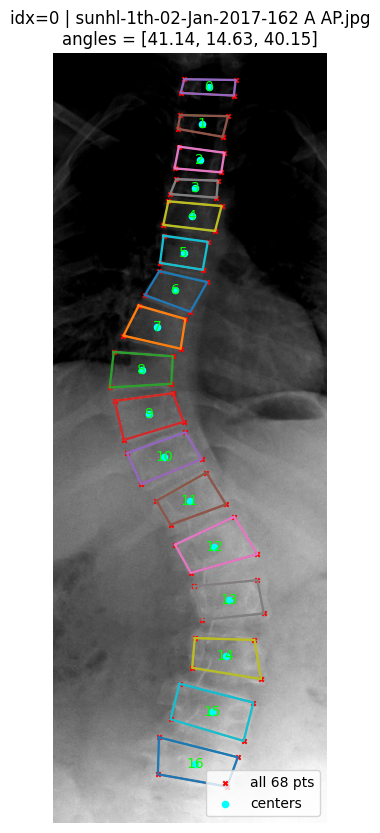

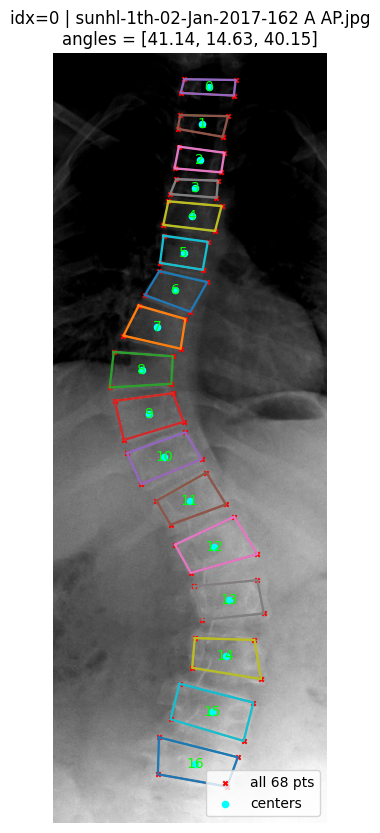

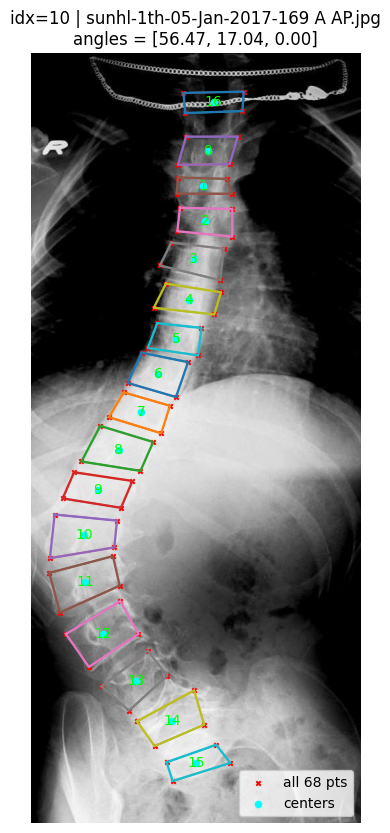

In [2]:
from utils import decode_landmarks_136, visualize_sample


# ============================================================
# Usage Examples
# ============================================================

# Visualize sample at index 0
visualize_sample(0)

# Visualize with all features enabled
visualize_sample(0, show_pairs=True, show_quads=True, show_centers=True)

# Visualize sample at index 10 and save
visualize_sample(10, save_path="./debug_10.png")

# ============================================================
# Custom visualization example
# ============================================================
# You can also access landmark data directly:
# v136 = lm.iloc[idx].values.astype(np.float32)
# pts, left, right, corners = decode_landmarks_136(v136)
